<a href="https://colab.research.google.com/github/jvlad/machine_learning_exercises/blob/main/coding_ai_best_practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best AI Coding Practices for Running Experiments

## 1. Install and Import Libraries

In [1]:
# install and import libraries
!pip install --upgrade --quiet git+https://github.com/haven-ai/haven-ai


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import tqdm.notebook as tqdm
import os
import torch
import pickle
import torchvision
import numpy as np
import json

from haven import haven_results as hr
from haven import haven_utils as hu


## 2. Define Needed Functions

In [3]:
def get_model(exp_dict):
    model = torch.nn.Linear(784, 10)
    opt = torch.optim.Adam(model.parameters(), lr=exp_dict["lr"])

    return model, opt

def get_loader(exp_dict):
    dataset_name = exp_dict['dataset']
    if dataset_name  == 'mnist':
      dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=None)
      return torch.utils.data.DataLoader(dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True)
    elif dataset_name == 'cifar':
      dataset = torchvision.datasets.CIFAR10(root="data", train=True, transform=None)
      return torch.utils.data.DataLoader(dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True)
    else:
      raise ValueError(f"Dataset set [{dataset_name}] isn't supported.")

def save_pkl(fname, file):
    os.makedirs(os.path.split(fname)[0], exist_ok=True)
    with open(fname, "wb") as f:
         pickle.dump(file, f)

def save_json(fname, file):
    os.makedirs(os.path.split(fname)[0], exist_ok=True)
    with open(fname, 'w') as json_file:
      json.dump(file, json_file, indent=4)

def isIdAssigned(exp_dict):
    return bool(exp_dict.get("id"))

def train_on_loader(model, opt, train_loader):
    train_list = []
    for batch in train_loader:
        # Get Images
        X = [torch.FloatTensor(np.array(x[0])) for x in batch]
        X = torch.stack(X).view(-1, 784)

        # Get labels
        y = [x[1] for x in batch]

        # Forward pass
        out = model.forward(X)
        loss = torch.nn.functional.cross_entropy(out, torch.LongTensor(y))

        # Backpropagate
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Get scores for one iteration
        acc = (out.argmax(dim=1) == torch.LongTensor(y)).float().mean()
        train_list += [{"loss": float(loss), "acc": float(acc)}]

    # Get avg scores for one epoch
    train_dict_avg = pd.DataFrame(train_list).mean().to_dict()

    return train_dict_avg

# Define the function to load data from a directory
def load_data_from_directory(directory_path):
    data = {}

    # Load exp_dict from exp_dict.json
    exp_dict_file = os.path.join(directory_path, 'exp_dict.json')
    if os.path.exists(exp_dict_file):
        with open(exp_dict_file, 'r') as json_file:
            data['exp_dict'] = json.load(json_file)

    # Load score_list from score_list.pkl
    score_list_file = os.path.join(directory_path, 'score_list.pkl')
    if os.path.exists(score_list_file):
        with open(score_list_file, 'rb') as pickle_file:
            data['score_list'] = pickle.load(pickle_file)

    return data

def get_score_data(exp_list, savedir_base):
  # Initialize a list to store the loaded data
  score_data = []

  # Load data from each directory and append it to the list
  for exp_dict in exp_list:
      score_data.append(load_data_from_directory(os.path.join(savedir_base, hu.hash_dict(exp_dict))))

  return score_data

def get_score_dataframe(exp_list, savedir_base):
  score_data = get_score_data(exp_list, savedir_base)
  data_list = []

  for data in score_data:
      exp_dict = data.get('exp_dict', {})
      score_list = data.get('score_list', [])

      if score_list:
          last_score = score_list[-1]

          # Combine keys from both exp_dict and last_score
          combined_keys = set(exp_dict.keys()) | set(last_score.keys())

          # Create a dictionary with combined keys and values
          combined_data = {**exp_dict, **last_score}

          data_list.append(combined_data)


  # Create the DataFrame
  df = pd.DataFrame(data_list)

  return df


## 3. Run Experiments & Save Results

In [6]:
# Define Training Validation Procedure
def trainval(exp_dict, savedir, args):
    """
    exp_dict: dictionary defining the hyperparameters of the experiment
    savedir: the directory where the experiment will be saved
    args: arguments passed through the command line
    """
    print(exp_dict)
    save_json(os.path.join(savedir, "exp_dict.json"), exp_dict)

    # Get MNIST dataset
    train_loader = get_loader(exp_dict)

    # Create Linear Model and Optimizer
    model, opt = get_model(exp_dict)

    # Define Score List
    score_list = []

    # Train and Validate
    for epoch in tqdm.tqdm(range(1), desc="Running TrainVal", leave=False):
        # Train for one epoch
        train_dict = train_on_loader(model, opt, train_loader)

        # Get Metrics from last iteration of the epoch
        score_dict = {"epoch": epoch,
                      "loss": train_dict["loss"],
                      "acc": train_dict["acc"]}

        # Save Metrics in "savedir" as score_list.pkl
        score_list += [score_dict]

        # Save pickle
        save_pkl(os.path.join(savedir, "score_list.pkl"), score_list)

        # Print Metrics
        print(pd.DataFrame(score_list).tail())

    print("Experiment done\n")

if __name__ == '__main__':
    # Define a list of experiments
    exp_list = []
    for lr in [1e-2, 1e-3, 1e-5]:
        exp_list += [{'lr':lr, 'dataset':'cifar', 'model':'linear'}]

    savedir_base = "results"

    # Launch experiments using the trainval function
    for exp_dict in exp_list:
      trainval(exp_dict, os.path.join(savedir_base, hu.hash_dict(exp_dict)), None)

{'lr': 0.01, 'dataset': 'cifar', 'model': 'linear'}


UnboundLocalError: local variable 'loader' referenced before assignment

## 4. Visualize the Results

        lr dataset   model  epoch       loss       acc
0  0.01000   mnist  linear      0  65.245255  0.853233
1  0.00100   mnist  linear      0   7.390091  0.852433
2  0.00001   mnist  linear      0  18.413120  0.491467
[{'exp_dict': {'lr': 0.01, 'dataset': 'mnist', 'model': 'linear'}, 'score_list': [{'epoch': 0, 'loss': 65.24525548191797, 'acc': 0.8532333333333333}]}, {'exp_dict': {'lr': 0.001, 'dataset': 'mnist', 'model': 'linear'}, 'score_list': [{'epoch': 0, 'loss': 7.39009117262761, 'acc': 0.8524333333333334}]}, {'exp_dict': {'lr': 1e-05, 'dataset': 'mnist', 'model': 'linear'}, 'score_list': [{'epoch': 0, 'loss': 18.41312003572172, 'acc': 0.49146666666666666}]}]


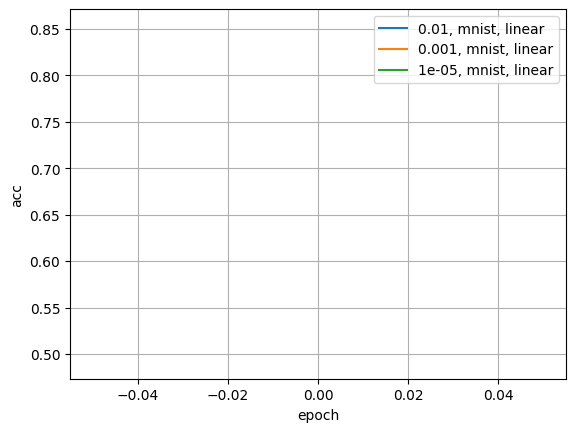

In [5]:
# Get Score data
savedir_base = "results"
score_df = get_score_dataframe(exp_list, savedir_base)

# Display Score Data in Table Form
print(score_df)

# Display Score Data in Plot Form
import matplotlib.pyplot as plt

# Define the function to plot data
score_data = get_score_data(exp_list, savedir_base)
print(score_data)
# Define the function to plot data
def plot(score_data, legend=None, y_axis=None, x_axis=None):
    # Create a new figure
    plt.figure()

    # Loop through each entry in score_data
    for data_entry in score_data:
        # Extract the score list and experiment dictionary
        score_list = data_entry.get('score_list', [])
        exp_dict = data_entry.get('exp_dict', {})

        # Use the specified keys from the score_list as x-axis and y-axis values
        x_values = [entry.get(x_axis, None) for entry in score_list]
        y_values = [entry.get(y_axis, None) for entry in score_list]

        # Create a label for the legend using the keys from the legend list
        if legend:
            label = ', '.join([str(exp_dict.get(key, key)) for key in legend])
        else:
            label = 'Entry'

        # Plot the y-axis and x-axis values using Matplotlib
        plt.plot(x_values, y_values, label=label)

    # Set labels for x and y axes using the provided arguments
    if x_axis:
        plt.xlabel(x_axis)
    if y_axis:
        plt.ylabel(y_axis)

    # Add legend
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()



plot(score_data, legend=['lr', 'dataset', 'model'], y_axis='acc', x_axis='epoch')
